# CAMS global aerosol forecasts

In [57]:
import numpy as np
import pandas as pd
import datetime
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.colors as mcol
from matplotlib import cm, ticker
from matplotlib.colors import ListedColormap
from zipfile import ZipFile
import cdsapi
import warnings
warnings.filterwarnings('ignore')
from platform import python_version
print("Python version: %s"%python_version())
print("Pandas version: %s"%pd.__version__)
print("Xarray version: %s"%xr.__version__)

Python version: 3.11.5
Pandas version: 2.1.1
Xarray version: 2023.12.0


In [41]:
start_date = '2024-08-30'
end_date = '2024-08-30'
lead_time_start = 0
lead_time_stop = 120
step_hours = 1
leadtime_hours = list(range(lead_time_start, lead_time_stop + lead_time_start, step_hours))
variables = ['total_aerosol_optical_depth_550nm']
bb_north = 90
bb_south = -90
bb_west = -180
bb_east = 180
area = [bb_north, bb_west, bb_south, bb_east]  

In [42]:
cams_dataset = 'cams-global-atmospheric-composition-forecasts'

In [43]:
DATADIR = 'data'
WDIR = f'cams_aer_opt_depth_{start_date}_{end_date}'

In [44]:
def validate_request_data(start_date, end_date, leadtime_hours):
    validation_result = True
    current_date = str(datetime.datetime.now())
    current_year = current_date[:4] 
    current_month = current_date[5:7]
    current_day = current_date[8:10]

    end_date_split = datetime.datetime.strptime(end_date, '%Y-%m-%d')
    end_day = end_date_split.day
    
    # test forecast days
    if (end_day > int(current_day)):
        print('The last forecast day must be the current one, {:s}/{}, or a previous one.'.format(current_day, current_month))
        validation_result = False
    # test leadtime periods
    if(len(leadtime_hours) > 120):
        print('The maximum lead time forecast is 120 hours (5 days)')
        validation_result = False
        
    return validation_result

In [45]:
print('The request is valid: {:b}'.format(validate_request_data(start_date, end_date, leadtime_hours)))

The request is valid: 1


In [46]:
request = {
        'variable': variables,
		'date': f'{start_date}/{end_date}',
        'time': f'{init_hour}:00',
        'leadtime_hour': leadtime_hours,
        'type': 'forecast',
        'area': area,
        'format': 'netcdf_zip',
    }

In [47]:
import cdsapi

c = cdsapi.Client()
c.retrieve(cams_dataset, request, f'{DATADIR}/{WDIR}.zip')

2024-08-30 15:13:37,062 INFO Welcome to the CDS
2024-08-30 15:13:37,064 INFO Sending request to https://ads.atmosphere.copernicus.eu/api/v2/resources/cams-global-atmospheric-composition-forecasts
2024-08-30 15:13:37,232 INFO Request is completed
2024-08-30 15:13:37,235 INFO Downloading https://download-0003-ads-clone.copernicus-climate.eu/cache-compute-0003/cache/data0/adaptor.mars_constrained.internal-1725023332.3732152-1568-8-d40ec6ed-628d-45fa-99b2-ee6d783dcae9.zip to data/cams_aer_opt_depth_2024-08-30_2024-08-30.zip (92.9M)
2024-08-30 15:13:51,439 INFO Download rate 6.5M/s   


Result(content_length=97423116,content_type=application/zip,location=https://download-0003-ads-clone.copernicus-climate.eu/cache-compute-0003/cache/data0/adaptor.mars_constrained.internal-1725023332.3732152-1568-8-d40ec6ed-628d-45fa-99b2-ee6d783dcae9.zip)

In [48]:
with ZipFile(f'{DATADIR}/{WDIR}.zip', 'r') as zipObj:
   zipObj.extractall(path=f'{DATADIR}/{WDIR}/')

In [49]:
aerosol_depth_ds = xr.open_dataset(f'{DATADIR}/{WDIR}/data.nc') 
aerosol_depth_ds

<xarray.Dataset>
Dimensions:    (longitude: 900, latitude: 451, time: 120)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.6 -179.2 ... 178.8 179.2 179.6
  * latitude   (latitude) float32 90.0 89.6 89.2 88.8 ... -89.2 -89.6 -90.0
  * time       (time) datetime64[ns] 2024-08-30 ... 2024-09-03T23:00:00
Data variables:
    aod550     (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2024-08-30 13:08:51 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [54]:
aod550_da = aerosol_depth_ds['aod550']
aod550_da

<xarray.DataArray 'aod550' (time: 120, latitude: 451, longitude: 900)>
[48708000 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.6 -179.2 ... 178.8 179.2 179.6
  * latitude   (latitude) float32 90.0 89.6 89.2 88.8 ... -89.2 -89.6 -90.0
  * time       (time) datetime64[ns] 2024-08-30 ... 2024-09-03T23:00:00
Attributes:
    units:      ~
    long_name:  Total Aerosol Optical Depth at 550nm

In [55]:
lead_times = aod550_da['time']
aod550_lt0_da = aod550_da.sel(time=lead_times[0])

In [50]:
def create_figure(): 
    fig = plt.figure(figsize=(20,10))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.OCEAN)
    ax.add_feature(cartopy.feature.LAND, edgecolor='black')
    ax.coastlines()
    ax.set_extent([bb_west, bb_east, bb_south, bb_north], ccrs.PlateCarree())
    gl = ax.gridlines(draw_labels=True, linestyle='--')
    return fig, ax

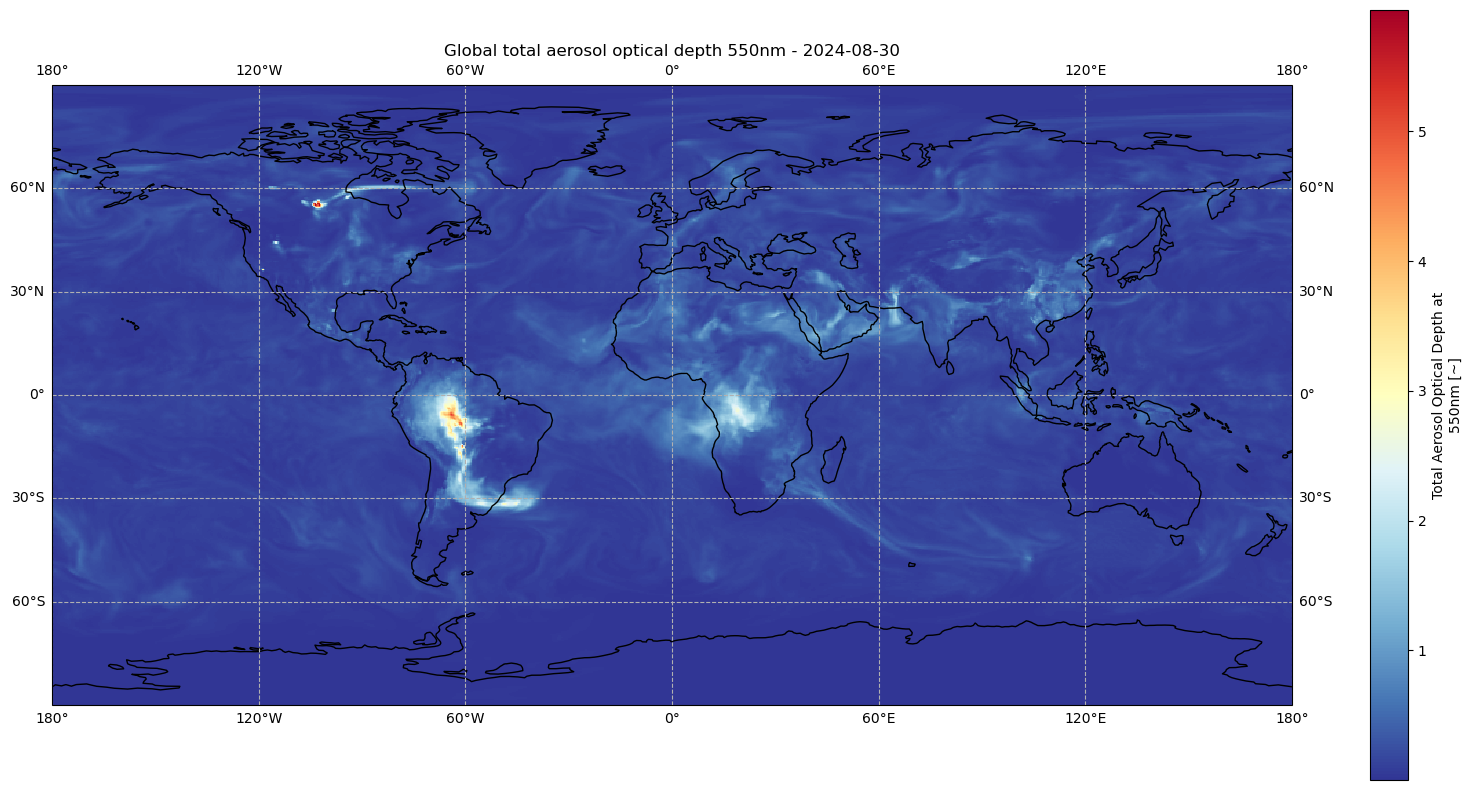

In [71]:
_, ax = create_figure()
forecast_day = str(lead_times[0].to_numpy())[:10]
aod550_lt0_da.plot.pcolormesh(ax=ax, x='longitude', y='latitude', add_colorbar=True, cmap='RdYlBu_r')
plt.title('Global total aerosol optical depth 550nm - {0:s}'.format(forecast_day))
plt.savefig('forecast_aod550.png')